In [1]:
%reload_ext autoreload
%autoreload 2

# Static potential: double well

In [2]:

#!/usr/bin/env python
# -*- coding:utf-8 -*-
#
# Created: 06/2023
# Author: Carmelo Mordini <cmordini@phys.ethz.ch>


import numpy as np
import matplotlib.pyplot as plt
from pytrans import objectives as obj
from pytrans.conversion import freq_to_curv
from pytrans.ions import Ca40
from pytrans.functions import zpspace
from pytrans.solver import solver, init_waveform

import cvxpy as cx
from models.surface_trap import SurfaceTrap

from pathlib import Path
data_dir = Path('.').resolve() / 'data'

trap = SurfaceTrap()


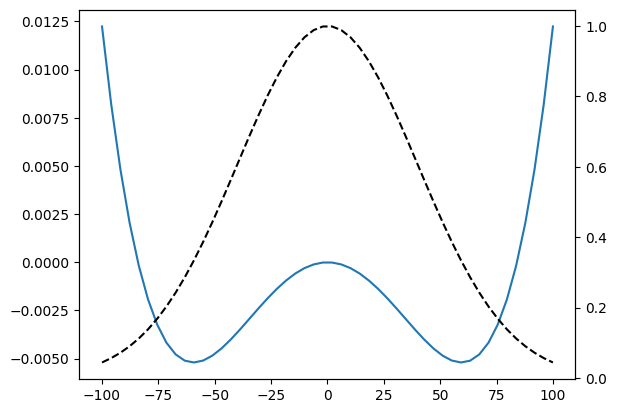

In [3]:

c2 = freq_to_curv(-0.6e6, ion=Ca40)
c4 = 1e16

n_samples = 1
ion = Ca40

L = 100e-6
x = np.linspace(-L, L, 50)
potential = 1/2 * c2 * x**2 + 1/24 * c4 * x**4
fit_sigma = 40e-6
fit_weight = np.exp(-x**2 / 2 / fit_sigma**2)

y0 = 0
z0 = trap.z0


fig, ax = plt.subplots()
ax.plot(x*1e6, potential)

ax2 = ax.twinx()
ax2.plot(x*1e6, fit_weight, 'k--')


In [4]:
e_top = [e for e in trap.electrodes if 'top' in e]
e_bot = [e.replace('top', 'bot') for e in e_top]

e_top, e_bot

(['DCintop', 'DCtop1', 'DCtop2', 'DCtop3', 'DCtop4', 'DCtop5'],
 ['DCinbot', 'DCbot1', 'DCbot2', 'DCbot3', 'DCbot4', 'DCbot5'])

In [5]:

waveform = init_waveform(n_samples, trap.n_electrodes)
offset = cx.Variable()

objectives = [
    obj.PotentialObjective(waveform[0], trap, x, y0, z0, ion, value=potential + offset, pseudo=False, local_weights=fit_weight),
    obj.GradientObjective(waveform[0], trap, 0, y0, z0, ion, value=0, weight=1e3),
    obj.VoltageObjective(waveform, 25, constraint_type='<='),
    obj.VoltageObjective(waveform, -25, constraint_type='>='),
    obj.SymmetryObjective(waveform, e_top, e_bot, trap),
    obj.SymmetryObjective(waveform, 'DCtop1', 'DCtop5', trap),
    obj.SymmetryObjective(waveform, 'DCtop2', 'DCtop4', trap),
]

_ = solver(objectives, verbose=False)
waveform = waveform.value  # get array from cvxpy variable
assert waveform is not None

savename = data_dir / 'waveform_double_well.npy'
print(f"Saving waveform as ndarray to {savename}")
np.save(savename, waveform)


Saving waveform as ndarray to D:\Scratch\pytrans-examples\examples\data\waveform_double_well.npy


## Analysis

In [37]:
import numpy as np
import matplotlib.pyplot as plt

from models.surface_trap import SurfaceTrap
from models.surface_trap.plot import plot_voltages_on_trap
from pytrans.analysis import analyse_potential
from pytrans.plotting.plotting import plot_potential_make_layout, plot_potential, plot3d_potential

from pytrans.ions import Ca40

trap = SurfaceTrap()
waveform = np.load(data_dir / 'waveform_double_well.npy')
voltages = waveform[0]

r0 = (0, 0, trap.z0)
roi = (L, 10e-6, 10e-6)

res = analyse_potential(trap, voltages, ions=[Ca40] * 2, ion1=Ca40,
                        r0=r0, roi=roi, find_3dmin=False, verbose=False, plot=False)

res


--------------
Trap potential analysis for ion Ca40: 
Equilibrium position [um]
[ 0.     0.    67.082]
Gradient [V/m]
[-0.  0. -0.]
Displacement at 1 MHz [um]
[-0.  0. -0.]
Hessian [V/m2]
[[-6.7374e+06 -3.7234e-03 -9.2283e-04]
 [-3.7234e-03  7.4694e+08  1.0017e-01]
 [-9.2283e-04  1.0017e-01  4.6869e+08]]
Normal mode frequencies [MHz]
[-0.641902 5.35384 6.75877]
Eigenvectors
[[1 4.94e-12 1.94e-12]
 [-1.94e-12 -3.6e-10 1]
 [4.94e-12 -1 -3.6e-10]]
Tilt angle of mode 2 (6.76): -180.00°
--------------
Mode solver analysis for ion crystal [Ca40, Ca40]: 
Equilibrium positions [um]
[[-57.6431   0.      66.7566]
 [ 57.6433   0.      66.7567]]
Normal modes
  Freq [MHz]                    Ca40                                Ca40
------------  ----------  ----------  ----------  ----------  ----------  ----------
      0.8386  -0.7141      3.423e-09  -0.008367   -0.7        -3.267e-10   0.008202
      0.8387   0.7        -3.355e-09   0.008202   -0.7141     -3.34e-10    0.008367
      5.526   -0.00

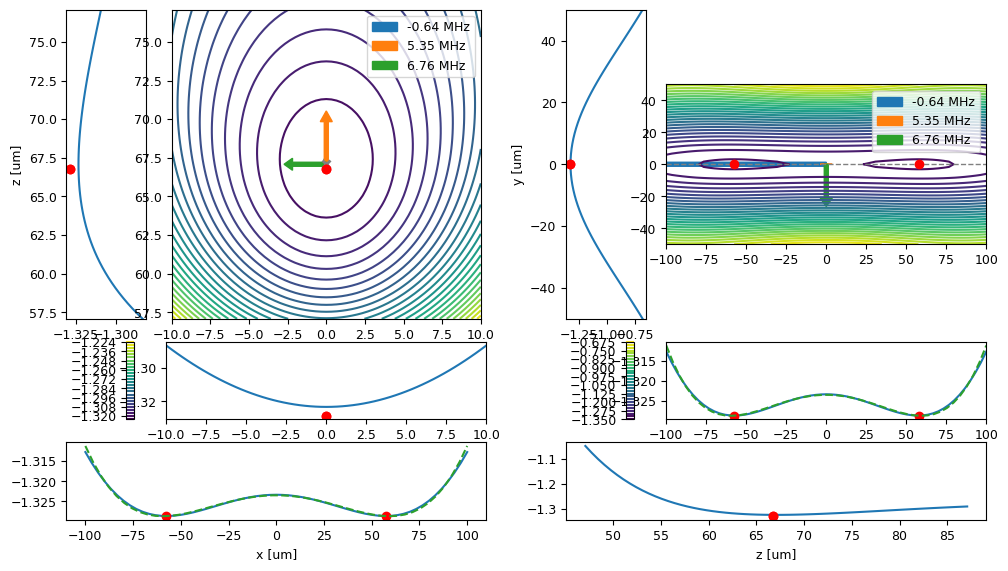

In [38]:

fig, axes = plot_potential_make_layout(2)
roi1 = (100e-6, 10e-6, 10e-6)
_ = plot_potential(trap, voltages, Ca40, r0, roi1, trap_axis='x', axes=axes[0], analyse_results=res)
axes[0][0].plot(x*1e6, potential + offset.value, '--')

roi1 = (100e-6, 50e-6, 20e-6)
_ = plot_potential(trap, voltages, Ca40, r0, roi1, trap_axis='z', axes=axes[1], analyse_results=res)
axes[1][1].plot(x*1e6, potential + offset.value, '--')


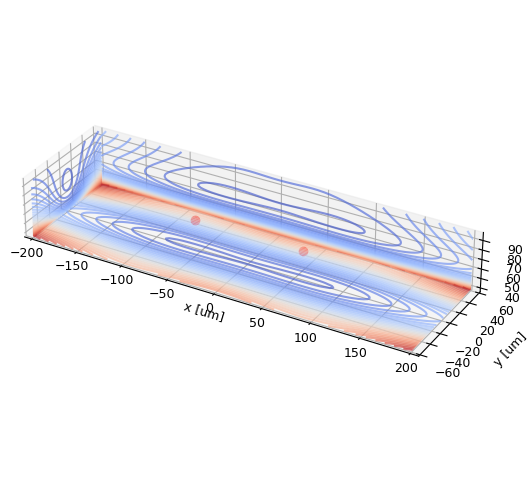

In [48]:

roi1 = (200e-6, 60e-6, 30e-6)
_ = plot3d_potential(trap, voltages, Ca40, r0, roi1, analyse_results=res)


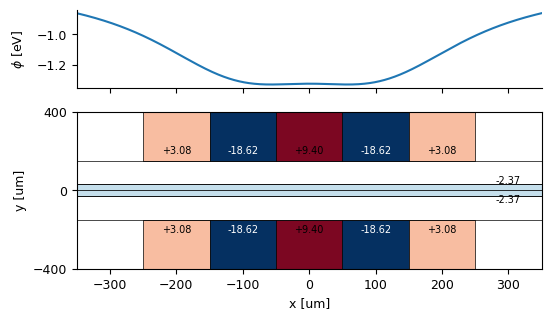

In [40]:

_ = plot_voltages_on_trap(trap, waveform[0])
